# 对用户进行聚类

数据来源于Kaggle竞赛：Event Recommendation Engine Challenge，根据events they’ve responded to in the past user demographic information what events they’ve seen and clicked on in our app 用户对某个事件是否感兴趣  

竞赛官网：https://www.kaggle.com/c/event-recommendation-engine-challenge/data  

由于用户众多（3w+），可以对用户进行聚类用户描述信息在users.csv文件：共7维特征  
user_id  
locale：地区，语言  
birthyear：出身年  
gender：性别  
joinedAt：用户加入APP的时间，ISO-8601 UTC time  
location：地点  
timezone：时区    
 
后101列为词频：count_1, count_2, ..., count_100，count_other    
count_N：活动描述出现第N个词的次数    
count_other：除了最常用的100个词之外的其余词出现的次数    
 
根据活动的关键词（count_1, count_2, ..., count_100，count_other属性）做聚类    

由于样本数目较多，本项目使用MiniBatchKMeans。  

In [250]:
#导入必要的工具包
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

from sklearn.decomposition import PCA
import time

import matplotlib.pyplot as plt
%matplotlib inline

读取已筛选好的数据

In [251]:
data = pd.read_csv("target_event.csv")
data.head()

,event_id,user_id,start_time,city,state,zip,country,lat,lng,c_1,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
0,684921758,3647864012,2012-10-31T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0,1,0,0,0,0,0,0,0,9
1,244999119,3476440521,2012-11-03T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,2,...,0,0,0,0,0,0,0,0,0,7
2,3928440935,517514445,2012-11-05T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,12
3,2582345152,781585781,2012-10-30T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,8
4,1051165850,1016098580,2012-09-27T00:00:00.001Z,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,9


In [252]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Columns: 110 entries, event_id to c_other
dtypes: float64(2), int64(103), object(5)
memory usage: 1.3+ MB


可看出每个样本共有110个特征，本次项目只对活动关键词（count_1, count_2, ..., count_100，count_other属性）做聚类，故只需保留着101维数据即可，将其他的特征全部移除

In [253]:
X_train = data.drop(["event_id","user_id","start_time","city","state","zip","country","lat","lng"],axis=1)

In [254]:
X_train.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,...,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
0,2,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,9
1,2,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
3,1,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,1,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,9


In [255]:
# 输入的特征维数和样本数目
print('the shape of data: {}'.format(X_train.shape))

the shape of data: (1532, 101)


数据已准备好，共101维特征，1532个样本

# 直接聚类

使用K-mean算法，此处需要调试超参数K（质心的数目），由于没有y标签，所以无法使用外部评价指标，只能使用内部评价指标Silhouette Coefficient和Calinski-Harabasz Index，这两个评价指标的分数越高，说明聚类效果越好。  

这里选用MiniBatchKMeans（K-mean算法变种），采用随机小批量的数据子集减少计算时间，类似于随机梯度下降法。MiniBatchKMeans加快了收敛速度，但在测试集上也降低了聚类的效果，但在实际项目中，降低效果表现并不明显，可能反而因为增加了泛化能力，在实际中得到更好的聚类效果

In [256]:
# 一个参数点（聚类数据为K）的模型
def K_cluster_analysis(K, X_train):
    start = time.time()
    
    #print("K-means begin with clusters: {}".format(K));
    
    #K-means,在训练集上训练
    mb_kmeans = MiniBatchKMeans(n_clusters = K)
    mb_kmeans.fit(X_train)
    
    # K值的评估标准
    #常见的方法有轮廓系数Silhouette Coefficient和Calinski-Harabasz Index
    #这两个分数值越大则聚类效果越好
    CH_score_calinski = metrics.calinski_harabaz_score(X_train,mb_kmeans.predict(X_train))
    CH_score_silhouett = metrics.silhouette_score(X_train,mb_kmeans.predict(X_train))
    
    
    end = time.time()
    print("CH_score_calinski: {}, CH_score_silhouett: {},time elaps:{}".format(CH_score_calinski, CH_score_silhouett, int(end-start)))
    
    return CH_score_calinski,CH_score_silhouett

轮廓系数Silhouette Coefficient的评价原理是计算类内散度和类间散度，如果类内散度越小，类间散度越大，则计算的结果数值越大，也就说明聚类效果越好，取值范围[-1,1]，一般大于0.5表示聚类效果不错  
CH索引Calinski-Harabasz Index和轮廓系数原理差不多，只是计算公式不同，在给定K的情况下，使用欧式距离计算类间散度和类内散度，计算速度更快点，也是分值越大越好

In [257]:
# 设置超参数（聚类数目K）搜索范围
Ks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

CH_score_calinski = []
CH_score_silhouett = []
for K in Ks:
    ch_ca, ch_si = K_cluster_analysis(K, X_train)
    CH_score_calinski.append(ch_ca)
    CH_score_silhouett.append(ch_si)

CH_score_calinski: 3565.9123030743863, CH_score_silhouett: 0.5296773475808788,time elaps:0
CH_score_calinski: 2348.641154660084, CH_score_silhouett: 0.252169663017688,time elaps:0
CH_score_calinski: 1359.382463028583, CH_score_silhouett: 0.17953294944336143,time elaps:0
CH_score_calinski: 1073.1963098834542, CH_score_silhouett: 0.20813930917961881,time elaps:0
CH_score_calinski: 1346.308023779811, CH_score_silhouett: 0.16907376224880957,time elaps:0
CH_score_calinski: 1197.4102010100305, CH_score_silhouett: 0.11428335250155786,time elaps:1
CH_score_calinski: 1184.9930104001899, CH_score_silhouett: 0.1718551781700824,time elaps:1
CH_score_calinski: 1056.3171238256, CH_score_silhouett: 0.1676699669778822,time elaps:0
CH_score_calinski: 987.6267663686575, CH_score_silhouett: 0.18563989804490405,time elaps:0
CH_score_calinski: 875.8979606272376, CH_score_silhouett: 0.18729963341634698,time elaps:1


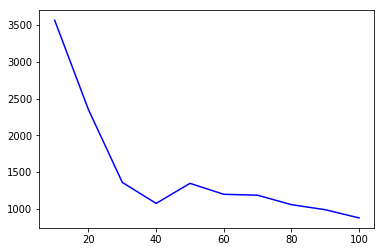

In [258]:
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）
plt.plot(Ks, np.array(CH_score_calinski), 'b-')

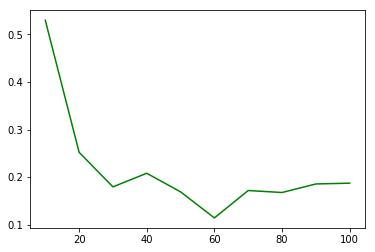

In [259]:
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）
plt.plot(Ks, np.array(CH_score_silhouett), 'g-')

K-means聚类方法需要设定分类的数目K，属于超参数，以上选择10~100内的10个K值分别进行聚类，并使用两个内部评价指标对聚类效果进行评价  
从以上两个曲线可看出，曲线的走势基本相同，都是随着聚类数目的增加，曲线下降，即聚类效果越来越差，可能是因为该数据集本身就不需要分成这么多类。在K值小于20的区间，两个评价指标分数下降的很快，故应尝试对前面的K值再进行调优，将K值候选范围缩小

In [260]:
Kss = range(2, 20, 1)
CH_score_calinski_1 = []
CH_score_silhouett_1 = []
for K in Kss:
    ch_ca, ch_si = K_cluster_analysis(K, X_train)
    CH_score_calinski_1.append(ch_ca)
    CH_score_silhouett_1.append(ch_si)

CH_score_calinski: 1932.9880510154362, CH_score_silhouett: 0.697130077903193,time elaps:0
CH_score_calinski: 3096.3450549795075, CH_score_silhouett: 0.6752776073984005,time elaps:0
CH_score_calinski: 3477.5985646131608, CH_score_silhouett: 0.6319787316611213,time elaps:0
CH_score_calinski: 3794.18897077505, CH_score_silhouett: 0.591289102675195,time elaps:0
CH_score_calinski: 4038.2362700138724, CH_score_silhouett: 0.5602413410722774,time elaps:0
CH_score_calinski: 4442.277558494651, CH_score_silhouett: 0.537059523558319,time elaps:0
CH_score_calinski: 4617.110102433553, CH_score_silhouett: 0.5398157328876557,time elaps:0
CH_score_calinski: 4184.131575320639, CH_score_silhouett: 0.4920325611683702,time elaps:0
CH_score_calinski: 4307.128959046696, CH_score_silhouett: 0.4624740990957102,time elaps:0
CH_score_calinski: 3559.7669660442657, CH_score_silhouett: 0.44555829395767604,time elaps:0
CH_score_calinski: 3546.2907931386844, CH_score_silhouett: 0.2866646442985484,time elaps:0
CH_scor

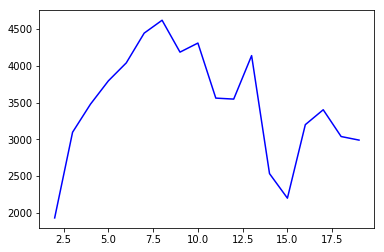

In [261]:
plt.plot(Kss, np.array(CH_score_calinski_1), 'b-')

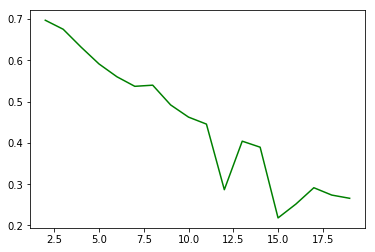

In [262]:
plt.plot(Kss, np.array(CH_score_silhouett_1), 'g-')

上图可看出，随着K值的加大，轮廓系数Silhouette Coefficient的分数依旧是不断下降的，但最好的评价分数已经可以达到0.7左右了，出现在第一个值的位置，即聚类最终分为两类的效果最好。  

CH索引Calinski-Harabasz Index的分数有点奇怪，在K=2左右，分数非常低，在K=7左右突然升高，之后的走势和轮廓系数类似，我猜测原因可能是数据还是适合分为两类，符合球型高斯，所以轮廓系数在K=2时分数很高，但此时两个簇并不是非常密集的，外围的数据点比较分散，而CH索引在计算时，是使用欧氏距离，类间散度为每一类中心到所有样本中心的距离平方和，类内散度为每一类自己样本的方差和，评价分数约等于类内散度除以类间散度，所以当两个类的中心到所有样本中心距离不变，每个类自己的样本变稀疏分散时就会造成分数变低，而整体上看还是属于两个单独的类

# 先PCA降维，再聚类

由于没有y标签，在做PCA（用较少的主成分得到较多的信息）降维时，没办法直接通过外部评价或实际的分类模型进行参数调优，但可以使用上面的内部评价分数进行调优  

原数据有101维，尝试降维至70,80,90,100 以轮廓系数Silhouette Coefficient为评价指标，看看效果如何  
上面未进行降维时，聚类效果基本是类别数越少，聚类效果越好，故再此验证的聚类效果也选择K=2~20之间

CH_score_calinski: 1935.1396077476873, CH_score_silhouett: 0.6977149132712752,time elaps:0
CH_score_calinski: 3075.3440276104516, CH_score_silhouett: 0.6625273550076787,time elaps:0
CH_score_calinski: 3710.6514205788826, CH_score_silhouett: 0.6326050778761051,time elaps:0
CH_score_calinski: 4013.2455989060713, CH_score_silhouett: 0.5958191560752147,time elaps:0
CH_score_calinski: 4488.624432872353, CH_score_silhouett: 0.5976172875960545,time elaps:0
CH_score_calinski: 4674.1375774451835, CH_score_silhouett: 0.5570943401621308,time elaps:0
CH_score_calinski: 4330.539436900941, CH_score_silhouett: 0.5321816741536269,time elaps:0
CH_score_calinski: 4593.788291981996, CH_score_silhouett: 0.5429578557185246,time elaps:0
CH_score_calinski: 4205.781220444305, CH_score_silhouett: 0.49282254956711763,time elaps:0
CH_score_calinski: 4102.490403461226, CH_score_silhouett: 0.4296944637523147,time elaps:0
CH_score_calinski: 2161.320844713968, CH_score_silhouett: 0.2570650561019746,time elaps:0
CH_s

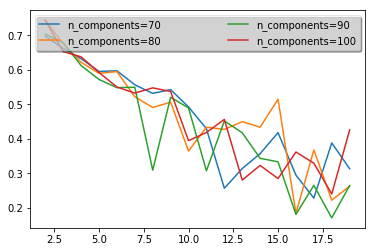

In [263]:
n_comp = range(70, 101, 10)
K_pca = range(2, 20, 1)

CH_score_silhouett_pca=[]

for n in n_comp:
    pca = PCA(n_components=n)
    #print("PCA begin with n_components: {}".format(n));
    pca.fit(X_train)
    
    X_train_pca = pca.transform(X_train)
    
    for K_0 in K_pca:
        ch_ca, ch_si = K_cluster_analysis(K_0, X_train_pca)
        #CH_score_calinski_pca.append(ch_ca)
        CH_score_silhouett_pca.append(ch_si)
    
    plt.plot(K_pca,np.array(CH_score_silhouett_pca),label="n_components=%d"%(n,))
    CH_score_silhouett_pca.clear()
    
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.show() 


从上面的结果可发现，进行PCA降维后，曲线和未进行降维之前的走势差不多，但降维为80左右时，最好的分数可达到0.75左右，也是出现在2个分类的时候，PCA可能改善了聚类效果，原因一方面可能是因为原数据101维中有些特征相关性比较强，降维后得到的数据更有有效，另一方面可能是因为K-means对球型高斯分布的聚类效果比较好，不适合扁长型的数据分布聚类，也不适合分布散度不同、类别样本不均衡的聚类，而PCA降维可能使样本的分布更加符合球型高斯分布，故得到了更好的效果

发现相同的代码，重复运行会出现不同的结果，有的聚类效果好点，有的差点，我感觉是因为K-means本来就不能保证达到全局最优解，因为聚类效果除了和K值有关，另外也跟给定质心的初值有关，每次运行代码，都是随机给定质心，可能给的质心会造成聚类效果特别差的情况，也有可能很好

小结  
PCA学习特征之间的相关性  
聚类学习样本之间的相关性